# 0.0 IMPORTANDO AS BIBLIOTECAS

In [1]:
import pylab
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

from pandas_profiling        import ProfileReport
from warnings                import simplefilter
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier
from xgboost                 import XGBClassifier
from sklearn.metrics         import accuracy_score, classification_report
from IPython.display         import Image

simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## 0.1 Funções

In [2]:
# Funções utilizadas no projeto

def tamanho():
    pylab.rcParams['figure.figsize'] = (15.0, 10.0)
tamanho()

def ml_error( model_name, y, yhat ):
    print(model_name)
    print(classification_report(y_test, y_pred))

## 0.2 Importando os dados

In [3]:
df_raw = pd.read_csv('diabetes.csv')

## 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## 1.1 Renomeando colunas

In [6]:
df1 = df1.rename(columns={'Pregnancies': 'gravidez', 'Glucose': 'glicose', 'BloodPressure': 'press_sangue',
                          'SkinThickness': 'esp_pele', 'Insulin': 'insulina', 'BMI': 'imc',
                          'DiabetesPedigreeFunction': 'hist_familiar', 'Age': 'idade', 'Outcome': 'resultado'})

In [7]:
df1.head()

gravidez  glicose  press_sangue  esp_pele  insulina   imc  hist_familiar  \
0         6      148            72        35         0  33.6          0.627   
1         1       85            66        29         0  26.6          0.351   
2         8      183            64         0         0  23.3          0.672   
3         1       89            66        23        94  28.1          0.167   
4         0      137            40        35       168  43.1          2.288   

   idade  resultado  
0     50          1  
1     31          0  
2     32          1  
3     21          0  
4     33          1

## 1.2 Dimensão dos dados

In [8]:
print('Numero de linhas:', df1.shape[0])
print('Numero de colunas:', df1.shape[1])

Numero de linhas: 768
Numero de colunas: 9


## 1.3 Tipos de dados

In [9]:
df1.dtypes

gravidez           int64
glicose            int64
press_sangue       int64
esp_pele           int64
insulina           int64
imc              float64
hist_familiar    float64
idade              int64
resultado          int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

gravidez         0
glicose          0
press_sangue     0
esp_pele         0
insulina         0
imc              0
hist_familiar    0
idade            0
resultado        0
dtype: int64

## 1.5 Descrição Estatística

In [11]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T



# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T



# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes     min     max    range        mean    median         std  \
0       gravidez   0.000   17.00   17.000    3.845052    3.0000    3.367384   
1        glicose   0.000  199.00  199.000  120.894531  117.0000   31.951796   
2   press_sangue   0.000  122.00  122.000   69.105469   72.0000   19.343202   
3       esp_pele   0.000   99.00   99.000   20.536458   23.0000   15.941829   
4       insulina   0.000  846.00  846.000   79.799479   30.5000  115.168949   
5            imc   0.000   67.10   67.100   31.992578   32.0000    7.879026   
6  hist_familiar   0.078    2.42    2.342    0.471876    0.3725    0.331113   
7          idade  21.000   81.00   60.000   33.240885   29.0000   11.752573   
8      resultado   0.000    1.00    1.000    0.348958    0.0000    0.476641   

       skew  kurtosis  
0  0.901674  0.159220  
1  0.173754  0.640780  
2 -1.843608  5.180157  
3  0.109372 -0.520072  
4  2.272251  7.214260  
5 -0.428982  3.290443  
6  1.919911  5.594954  
7  1.129597  0.643159  
8  0.635017 -1.600930

In [12]:
df1.describe()

gravidez     glicose  press_sangue    esp_pele    insulina  \
count  768.000000  768.000000    768.000000  768.000000  768.000000   
mean     3.845052  120.894531     69.105469   20.536458   79.799479   
std      3.369578   31.972618     19.355807   15.952218  115.244002   
min      0.000000    0.000000      0.000000    0.000000    0.000000   
25%      1.000000   99.000000     62.000000    0.000000    0.000000   
50%      3.000000  117.000000     72.000000   23.000000   30.500000   
75%      6.000000  140.250000     80.000000   32.000000  127.250000   
max     17.000000  199.000000    122.000000   99.000000  846.000000   

              imc  hist_familiar       idade   resultado  
count  768.000000     768.000000  768.000000  768.000000  
mean    31.992578       0.471876   33.240885    0.348958  
std      7.884160       0.331329   11.760232    0.476951  
min      0.000000       0.078000   21.000000    0.000000  
25%     27.300000       0.243750   24.000000    0.000000  
50%     32.000000       0.372500   29.000000    0.000000  
75%     36.600000       0.626250   41.000000    1.000000  
max     67.100000       2.420000   81.000000    1.000000

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

In [14]:
num_attributes.nunique()

gravidez          17
glicose          136
press_sangue      47
esp_pele          51
insulina         186
imc              248
hist_familiar    517
idade             52
resultado          2
dtype: int64

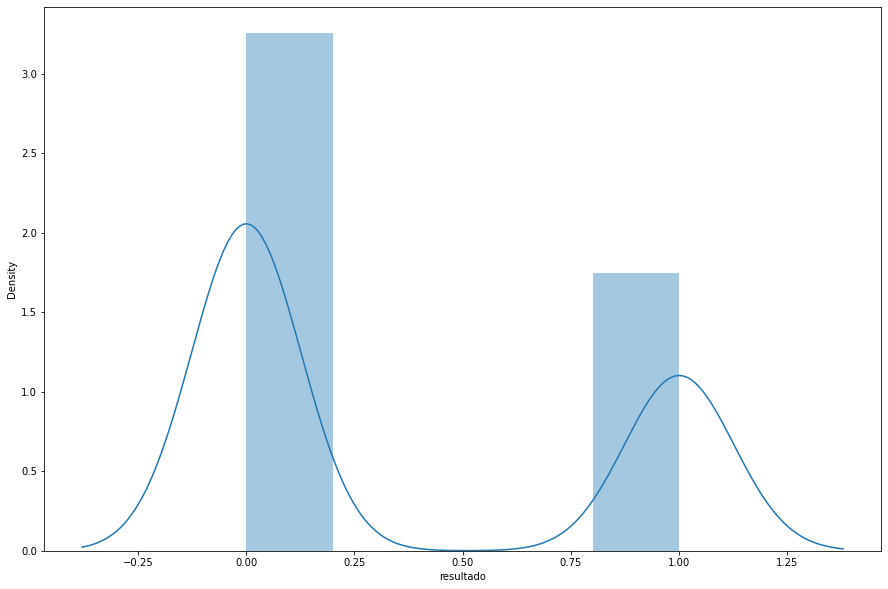

In [15]:
sns.distplot(df1['resultado']);

# 2.0 Engenharia de Atributos

In [16]:
df2 = df1.copy()

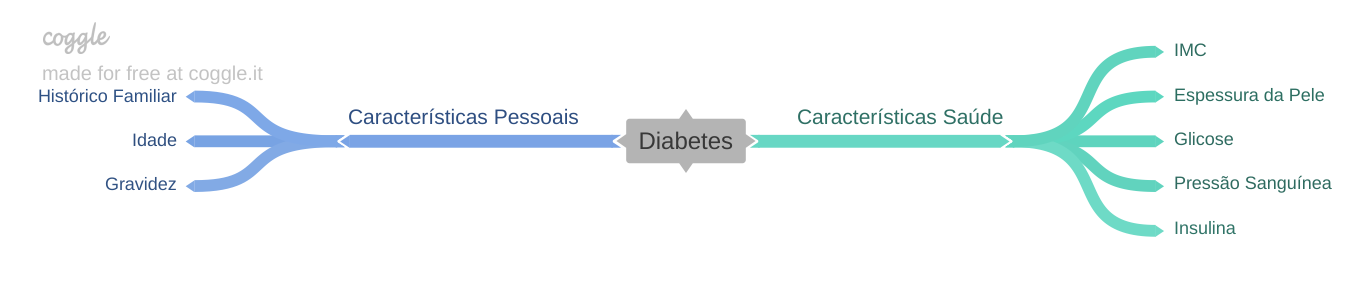

In [17]:
Image('Image.png')

## 2.1 Criação de Hipóteses

**1.** Quanto maior a idade, maior a chance de ter diabete

**2.** Quanto maior a idade, menor a espessura da pele

**3.** Quanto maior o histórico familiar, maior a chance de ter diabetes

**4.** Quanto mais vezes de gravidez, maior a chance de ter diabetes

**5.** Quanto maior o IMC, maior a pressão sanguínea

**6.** Quanto maior a insulina, maior a pressão sanguínea

# 3.0 Análise Exploratória de Dados (EDA)

In [18]:
df3 = df2.copy()

## 3.1 Análise Univariada

<AxesSubplot:xlabel='resultado'>

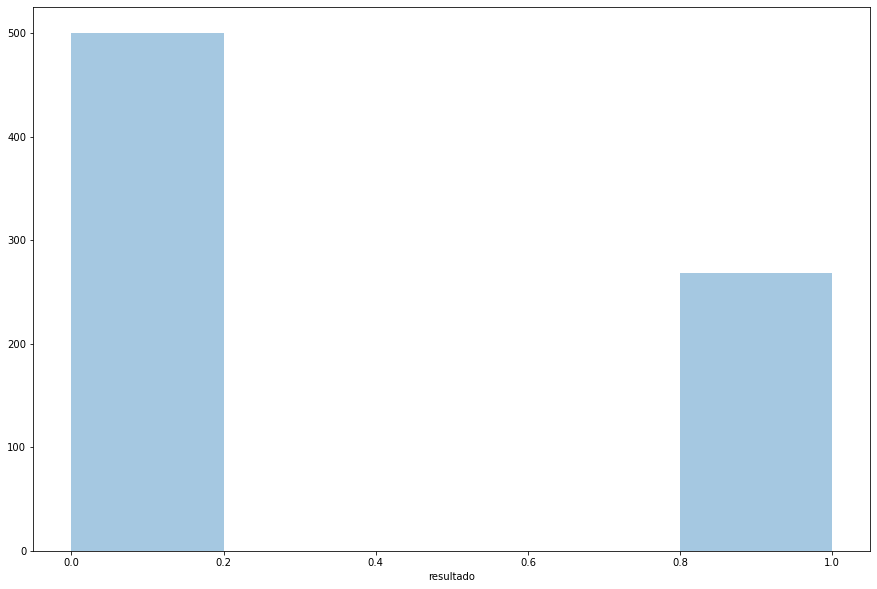

In [19]:
sns.distplot( df3['resultado'], kde=False)

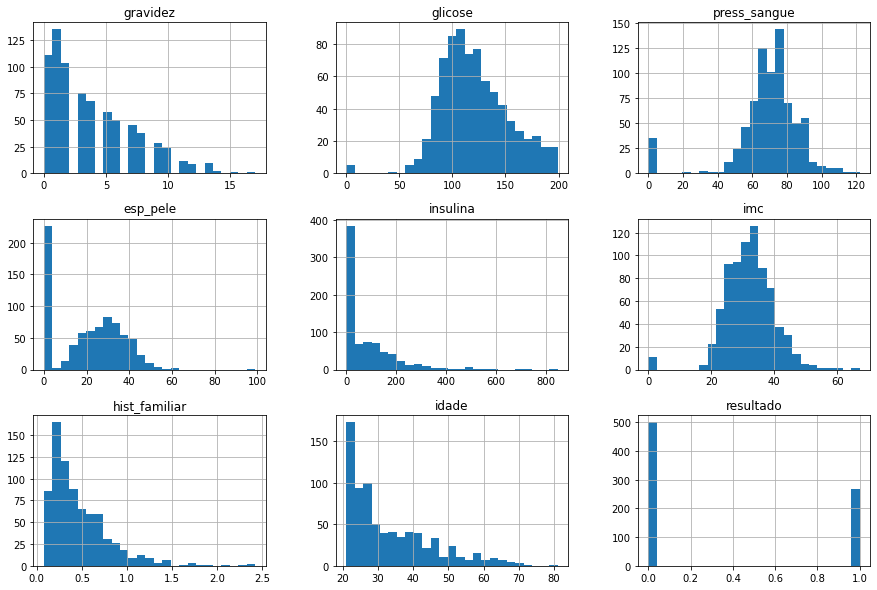

In [20]:
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
df3.hist( bins=25 );

## 3.2 Análise Bivariada

### 1. Quanto maior a idade, maior a chance de ter diabete

<AxesSubplot:xlabel='resultado', ylabel='idade'>

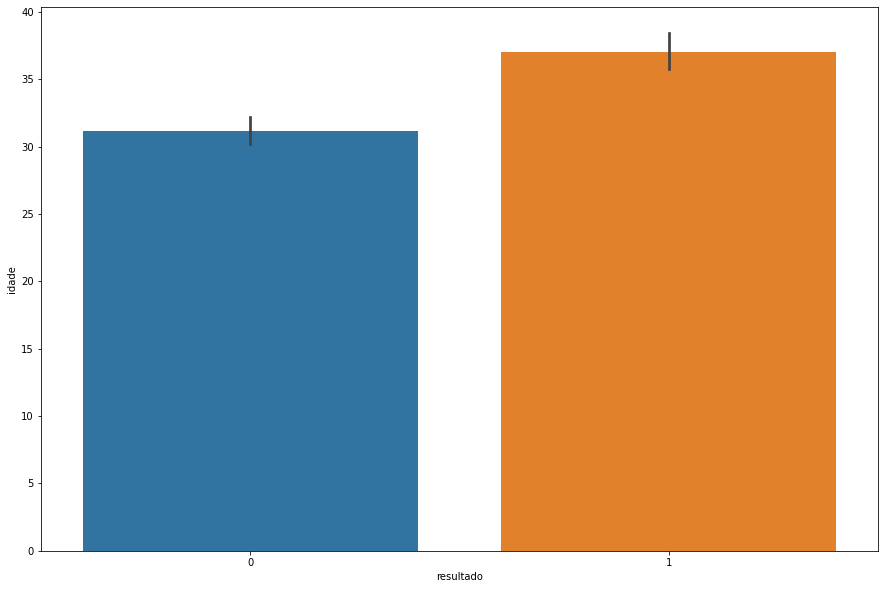

In [21]:
sns.barplot(x='resultado', y='idade', data=df3)

### 2. Quanto maior a idade, menor a espessura da pele

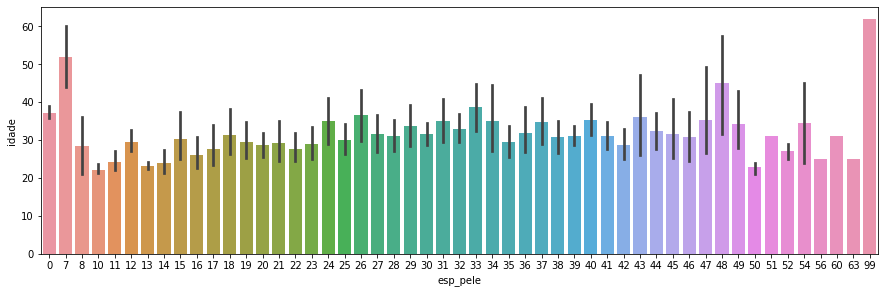

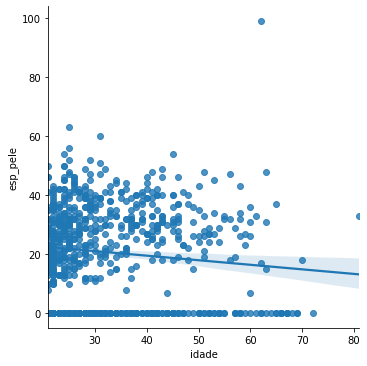

In [22]:
plt.subplot(2, 1,1);
sns.barplot(x='esp_pele', y='idade', data=df3);

sns.lmplot(x='idade', y='esp_pele', data=df3)

### 3. Quanto maior o histórico familiar, maior a chance de ter diabetes

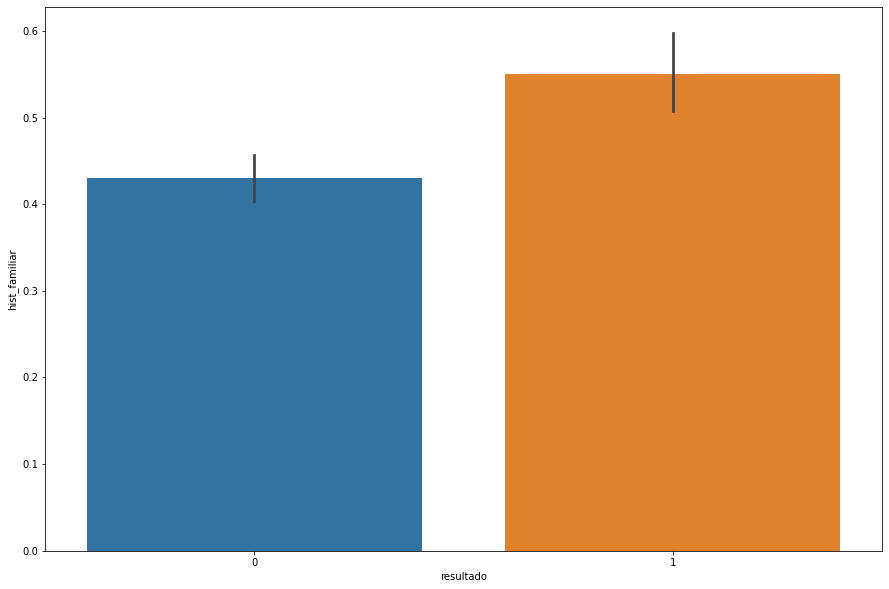

In [23]:
sns.barplot(x='resultado', y='hist_familiar', data=df3);

### 4. Quanto mais vezes de gravidez, maior a chance de ter diabetes

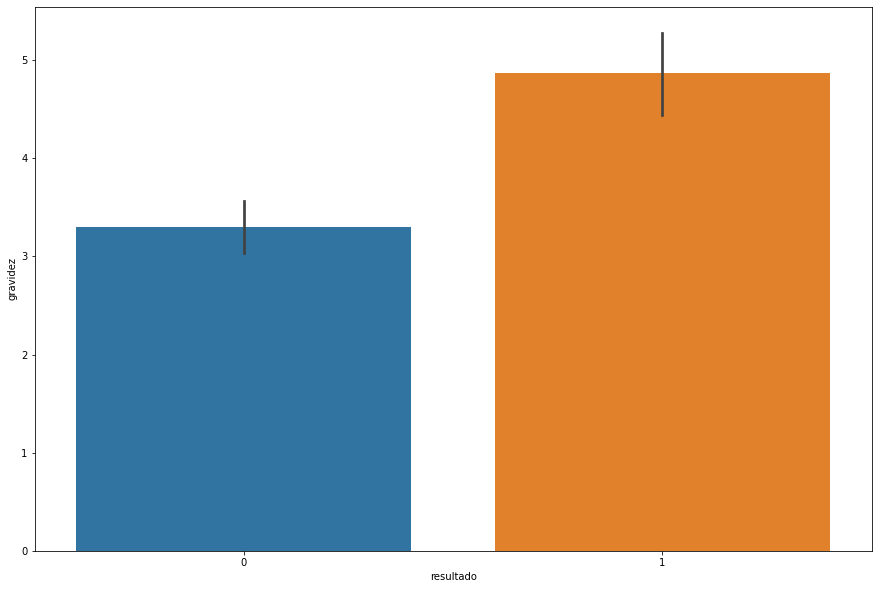

In [24]:
sns.barplot(x='resultado', y='gravidez', data=df3);

### 5. Quanto maior o IMC, maior a pressão sanguínea

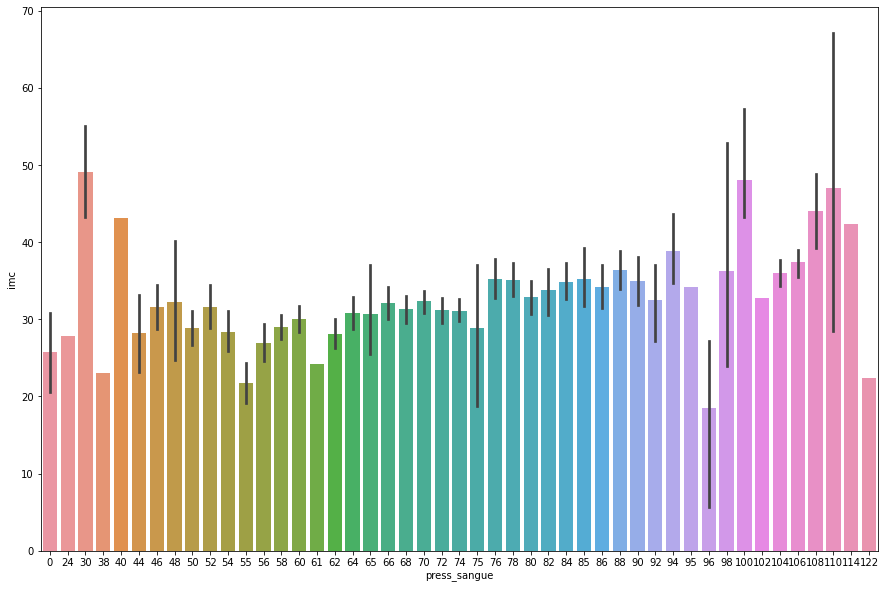

In [25]:
sns.barplot(x='press_sangue', y='imc', data=df3);

### 6. Quanto maior a insulina, maior a pressão sanguínea

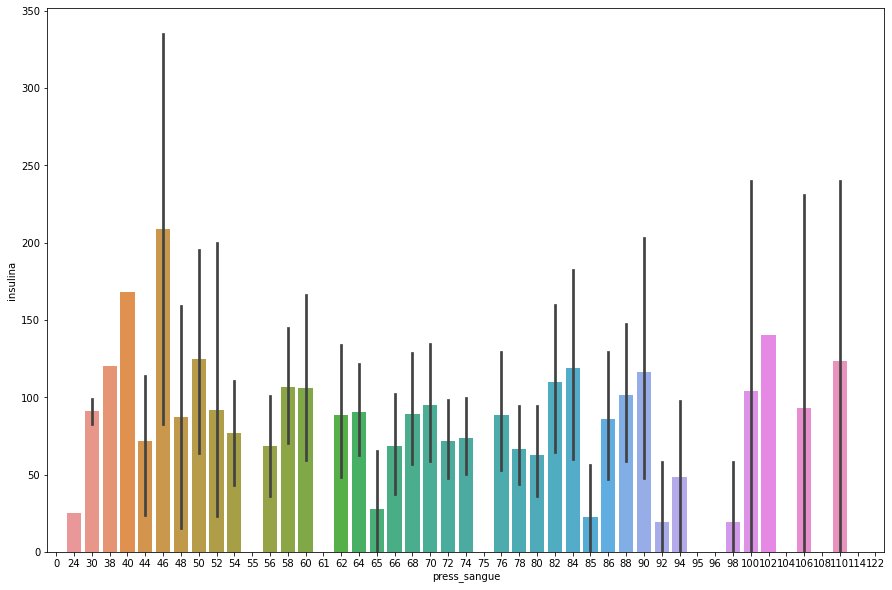

In [26]:
sns.barplot(x='press_sangue', y='insulina', data=df3);

## 3.3 Análise Multivariada

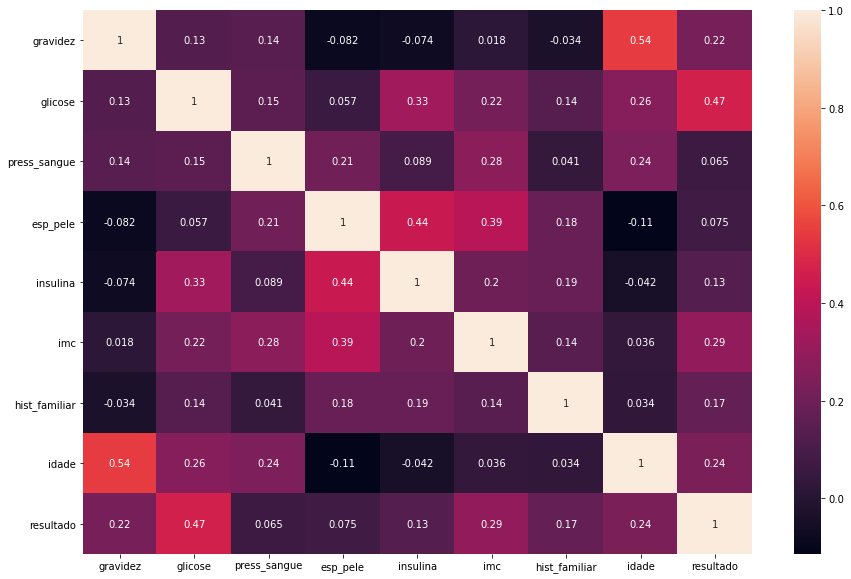

In [27]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

In [28]:
profile = ProfileReport(df3, title='Profiling Diabets',html={'style':{'full_width':True}})
profile

In [29]:
df3

gravidez  glicose  press_sangue  esp_pele  insulina   imc  hist_familiar  \
0           6      148            72        35         0  33.6          0.627   
1           1       85            66        29         0  26.6          0.351   
2           8      183            64         0         0  23.3          0.672   
3           1       89            66        23        94  28.1          0.167   
4           0      137            40        35       168  43.1          2.288   
..        ...      ...           ...       ...       ...   ...            ...   
763        10      101            76        48       180  32.9          0.171   
764         2      122            70        27         0  36.8          0.340   
765         5      121            72        23       112  26.2          0.245   
766         1      126            60         0         0  30.1          0.349   
767         1       93            70        31         0  30.4          0.315   

     idade  resultado  
0       50          1  
1       31          0  
2       32          1  
3       21          0  
4       33          1  
..     ...        ...  
763     63          0  
764     27          0  
765     30          0  
766     47          1  
767     23          0  

[768 rows x 9 columns]

# 4.0 PREPARAÇÃO DOS DADOS

In [30]:
df4 = df3.copy()

In [31]:
rs = RobustScaler()
mms = MinMaxScaler()

In [32]:
df4[['glicose', 'imc', 'hist_familiar']] = rs.fit_transform(df4[['glicose', 'imc', 'hist_familiar']].values)

df4[['gravidez', 'press_sangue', 'esp_pele', 'insulina', 'idade']] = mms.fit_transform(df4[['gravidez', 'press_sangue', 'esp_pele', 'insulina', 'idade']].values)

In [33]:
df4

gravidez   glicose  press_sangue  esp_pele  insulina       imc  \
0    0.352941  0.751515      0.590164  0.353535  0.000000  0.172043   
1    0.058824 -0.775758      0.540984  0.292929  0.000000 -0.580645   
2    0.470588  1.600000      0.524590  0.000000  0.000000 -0.935484   
3    0.058824 -0.678788      0.540984  0.232323  0.111111 -0.419355   
4    0.000000  0.484848      0.327869  0.353535  0.198582  1.193548   
..        ...       ...           ...       ...       ...       ...   
763  0.588235 -0.387879      0.622951  0.484848  0.212766  0.096774   
764  0.117647  0.121212      0.573770  0.272727  0.000000  0.516129   
765  0.294118  0.096970      0.590164  0.232323  0.132388 -0.623656   
766  0.058824  0.218182      0.491803  0.000000  0.000000 -0.204301   
767  0.058824 -0.581818      0.573770  0.313131  0.000000 -0.172043   

     hist_familiar     idade  resultado  
0         0.665359  0.483333          1  
1        -0.056209  0.166667          0  
2         0.783007  0.183333          1  
3        -0.537255  0.000000          0  
4         5.007843  0.200000          1  
..             ...       ...        ...  
763      -0.526797  0.700000          0  
764      -0.084967  0.100000          0  
765      -0.333333  0.150000          0  
766      -0.061438  0.433333          1  
767      -0.150327  0.033333          0  

[768 rows x 9 columns]

# 5.0 MODELOS DE MACHINE LEARNING

In [34]:
df5 = df4.copy()

## 5.1 Separando os dados em treino e teste

In [35]:
x = df5.drop(['resultado'], axis=1)
y = df5['resultado']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

## 5.2 Modelo Base

In [37]:
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

DummyClassifier()

In [38]:
y_pred = modelo.predict(x_test)
print('Acurácia:', accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))

Acurácia: 64.28571428571429
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        99
           1       0.00      0.00      0.00        55

    accuracy                           0.64       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.41      0.64      0.50       154



C:\Users\ialbuquerque\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ialbuquerque\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ialbuquerque\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

## 5.3 Random Forest

In [39]:
modelo1 = RandomForestClassifier()
modelo1.fit(x_train, y_train)

RandomForestClassifier()

In [40]:
y_pred = modelo1.predict(x_test)
print('acurácia',accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))

acurácia 75.32467532467533
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        99
           1       0.66      0.64      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



## 5.4 Decision Tree

In [41]:
modelo2 = DecisionTreeClassifier()
modelo2.fit(x_train, y_train)

DecisionTreeClassifier()

In [42]:
y_pred = modelo2.predict(x_test)
print('acurácia',accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))

acurácia 74.67532467532467
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        99
           1       0.63      0.71      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



## 5.5 XGBoost

In [43]:
modelo3 = XGBClassifier()
modelo3.fit(x_train, y_train)

[09:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
y_pred = modelo3.predict(x_test)
print('acurácia',accuracy_score( y_test, y_pred )*100)
print(classification_report(y_test, y_pred))

acurácia 68.83116883116884
              precision    recall  f1-score   support

           0       0.79      0.71      0.74        99
           1       0.55      0.65      0.60        55

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.70      0.69      0.69       154

